In [ ]:
### connect the drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
### set working directory....
%cd "/content/drive/MyDrive/Yemaachi_works"

/content/drive/MyDrive/Yemaachi_works


In [ ]:
### import biopython:
!pip install biopython
### install gspread:
!pip install --upgrade -q gspread

     |████████████████████████████████| 2.3 MB 5.0 MB/s 


In [ ]:
#### rating the limit of data reads
!pip install -q ratelimit

In [ ]:
##### check for the lists of folders in the directory:
#%ls -sh "/content/drive/MyDrive/Yemaachi_works/Cyclophosphamide /"
%ls -sh "/content/drive/MyDrive/Yemaachi_works/Cyclophosphamide "

total 932K
3.0K  all_CategoriesGenes.csv
 512  all_CategoriesGenes.gsheet
 15K  all-data_cyclophosphamide_clinical.tsv
182K  all-data_cyclophosphamide_variants.tsv
 512  all_data_snp.gsheet
 15K  all-data.tsv
235K  all_interactions_dataframe.csv
 512  all_interactions_dataframe.gsheet
4.0K  clinical_annotations_allele/
4.0K  clinical_annotations.csv
 44K  cpic_drug_recommendation.csv
 512  cpic_drug_recommendation.gsheet
 512  CYCLOPHOSPHAMIDE_genes.gsheet
 21K  CYCLOPHOSPHAMIDE.xlsx
 512 'known_genes_cyclophosphamide (1).gsheet'
8.0K  known_genes_cyclophosphamide.csv
 512  known_genes_cyclophosphamide.gsheet
1.0K 'PA2034 (1).tsv'
 75K  PA2034.pdf
108K  PA2035.pdf
3.0K  PA2035.tsv
4.0K  update_allele_data/
 512 'variants_annotations (1).gsheet'
 37K  variants_annotations.csv
 512  variants_annotations.gsheet
 512 'variants_genes_cyclophosphamide (1).gsheet'
 512 'variants_genes_cyclophosphamide (2).gsheet'
170K  variants_genes_cyclophosphamide.csv
 512  variants_genes_cyclophosphamide.

### Pipeline creation:

- Developing of pipeline for data extraction.

In [ ]:
### import the modules and packages needed
import pandas as pd
import numpy as np
from glob import glob
import requests
import re
import json
from urllib.request import urlretrieve
import Bio
from Bio import SeqIO, SearchIO, Entrez
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio.Blast import NCBIWWW
from Bio.Data import CodonTable
from ratelimit import limits
import time
from typing import List, Any

In [ ]:
#### check the version of biopython
print(Bio.__version__)

1.79


In [ ]:
### import already scraped data info for gene metabolism
capecitabine_genes = pd.read_csv("/content/drive/MyDrive/Yemaachi_works/Capecitabine/CAPECITABINE_genes.csv")
capecitabine_genes.head()

Unnamed: 0  ... score
0           0  ...  0.48
1           1  ...  0.21
2           2  ...  0.89
3           3  ...  0.89
4           4  ...  0.09

[5 rows x 9 columns]

In [ ]:
capecitabine_genes.columns

Index(['Unnamed: 0', 'interactionId', 'interactionTypes', 'geneName',
       'geneLongName', 'geneEntrezId', 'sources', 'pmids', 'score'],
      dtype='object')

In [ ]:
capecitabine_genes.shape

(36, 9)

In [ ]:
capecitabine_genes.geneName.value_counts()

TYMS       1
MTHFR      1
KRAS       1
CES1P1     1
HLA-G      1
ABCG2      1
CDH1       1
TP53       1
CES1       1
SELE       1
PIK3CA     1
BRAF       1
CDA        1
UMPS       1
PTGS2      1
ERBB2      1
CYP1A1     1
DLG5       1
MET        1
VEGFA      1
DPYD       1
ENOSF1     1
MGAT4A     1
AREG       1
ERCC1      1
ADCY2      1
MIR2054    1
REV3L      1
CYP19A1    1
SLC22A7    1
ABCB1      1
EXO1       1
MIR27A     1
PTEN       1
TYMP       1
TYMSOS     1
Name: geneName, dtype: int64

In [ ]:
### test pmids
capecitabine_genes.pmids[4][1:-1].split(",")

['24338217', ' 20530282']

In [ ]:
capecitabine_genes.pmids[0][1:-1]

'15134221, 16926630, 15866500, 15132128, 11752352, 15709193'

In [ ]:
#### extract all pmids
pmids_ = []
genes = []
for x,y in zip(capecitabine_genes.geneName,capecitabine_genes.pmids):
  if len(y[1:-1]) == 0:
    continue
  else:
    new_pmids = y[1:-1].split(",")
    for pmid in new_pmids:
      pmids_.append(pmid.strip())
      genes.append(x)

In [ ]:
#### combine feature together
genes_pmids = pd.DataFrame()
genes_pmids["genes"] = genes
genes_pmids["pmids"] = pmids_

In [ ]:
genes_pmids.head()

genes     pmids
0  TYMS  15134221
1  TYMS  16926630
2  TYMS  15866500
3  TYMS  15132128
4  TYMS  11752352

In [ ]:
capecitabine_genes.sources[0][1:-1]

"'ClearityFoundationBiomarkers', 'ClearityFoundationClinicalTrial', 'ChemblInteractions', 'GuideToPharmacology'"

In [ ]:
genes_pmids.shape

(98, 2)

In [ ]:
urlink = requests.get("https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/15134221/unicode").json()
urlink

{'date': '20190911',
 'documents': [{'id': '15134221',
   'infons': {},
   'passages': [{'annotations': [],
     'infons': {'type': 'title'},
     'offset': 0,
     'relations': [],
     'sentences': [],
     'text': 'Potential for predicting toxicity and response of fluoropyrimidines in patients.'},
    {'annotations': [],
     'infons': {'type': 'abstract'},
     'offset': 81,
     'relations': [],
     'sentences': [],
     'text': 'The efficacy of cancer therapy is compromised by the fact that there are currently no good ways to predict which patients will benefit from treatment. This long standing goal is closer to becoming a reality as more is learned about the molecules that affect the activities of various therapeutic agents. The fluoropyrimidine antimetabolites drugs have been in clinical use for over 4 decades and the cellular proteins important for their activities have been studied in detail. The most important are the major target enzyme, thymidylate synthase (TS) and the 

In [ ]:
urlink["documents"][0]["passages"][1]["text"]

'The efficacy of cancer therapy is compromised by the fact that there are currently no good ways to predict which patients will benefit from treatment. This long standing goal is closer to becoming a reality as more is learned about the molecules that affect the activities of various therapeutic agents. The fluoropyrimidine antimetabolites drugs have been in clinical use for over 4 decades and the cellular proteins important for their activities have been studied in detail. The most important are the major target enzyme, thymidylate synthase (TS) and the rate limiting enzyme in the degradation pathway, dihydropyrimidine dehydrogenase (DPD), equally important for the analogue capecitabine is thymidine phosphorylase (TP), which is rate limiting for activation of this prodrug. A number of assays are available for these enzymes, including enzyme activity measurements. quantitative PCR for RNA expression and immunological methods for protein expression. With each of these methods, more clin

In [ ]:
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from time import sleep

#### retrieve file
def retrieveDocuments(pmids=None):
  """
  Args:
    Takes the lists of all pmids for documents given the genes.
  """

  abstract_doc = []  ##### initial empy list to access abstract text
  title_doc = []     ##### the title of the article.

  url = "https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/"
  unicode = "/unicode"
  test = 0
  for pmid in tqdm(pmids,desc="collections of files:"):

    urlink = url + str(pmid) + unicode
    test += 1
    print(f"link {test}: {urlink}") ### print the links
    ### make a query to through the api
    jsonfile = requests.get(urlink).json()

    if len(jsonfile["documents"][0]["passages"]) == 1:
      ### check the num of elements in the list....
      title = jsonfile["documents"][0]["passages"][0]["text"]
      text = "No abstract"
      title_doc.append(title)
      abstract_doc.append(text)
    else:
    ### extract the abstract the title and abstract
      text = jsonfile["documents"][0]["passages"][1]["text"]
      title = jsonfile["documents"][0]["passages"][0]["text"]
      abstract_doc.append(text)
      title_doc.append(title)
    sleep(0.1)
  return abstract_doc,title_doc

### access the files.....
doc_abstract , title_doc = retrieveDocuments(genes_pmids.pmids)

collections of files::   0%|          | 0/78 [00:00<?, ?it/s]

link 1: https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/15134221/unicode
link 2: https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/16926630/unicode
link 3: https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/15866500/unicode
link 4: https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/15132128/unicode
link 5: https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/11752352/unicode
link 6: https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/15709193/unicode
link 7: https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/25026457/unicode
link 8: https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/26222057/unicode
link 9: https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/24338217/unicode
link 10: https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pubmed.cgi/BioC_json/20530282/unicode
link 11: 

In [ ]:
print(f"Total number extracted: \n \t\t {len(doc_abstract)} abstracts \n \t \t {len(title_doc)} titles")

Total number extracted: 
 		 78 abstracts 
 	 	 78 titles


In [ ]:
genes_pmids["doc_abstract"] = doc_abstract
genes_pmids["title_doc"] = title_doc
genes_pmids.head()

genes  ...                                          title_doc
0  TYMS  ...  Potential for predicting toxicity and response...
1  TYMS  ...  Synergistic cytotoxic interaction in hormone-r...
2  TYMS  ...  Rapid quantitation of plasma 2'-deoxyuridine b...
3  TYMS  ...  Enzyme expression profiles suggest the novel t...
4  TYMS  ...                  TTD: Therapeutic Target Database.

[5 rows x 4 columns]

In [ ]:
#### save the file
genes_pmids.to_csv("/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_genes_paper_summary.csv",index=False)

In [ ]:
%pwd

'/content/drive/My Drive/Yemaachi_works'

### Extract the full text for the papers:

- Using Biopython library.

In [ ]:
!pip install metapub

     |████████████████████████████████| 122kB 6.7MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 245kB 9.7MB/s 
     |████████████████████████████████| 92kB 6.8MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 7.2MB 11.1MB/s 
     |████████████████████████████████| 92kB 10.3MB/s 
     |████████████████████████████████| 348kB 41.3MB/s 
  Created wheel for metapub: filename=metapub-0.5.5-cp37-none-any.whl size=135372 sha256=644c3ecde753d9d2c77983a11c8b6438f261842d93236dcb9511f8672c452725
  Stored in directory: /root/.cache/pip/wheels/af/d9/fc/c2f13edf0a7d0d335a69417183acfb3e08896743a79067cbf3
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149801 sha256=7487382130c4e69ca46cec3513536da97ea399becc3755218764707ed180df45
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b4

In [ ]:
from metapub import FindIt,PubMedFetcher,MedGenFetcher,MedGenConcept

In [ ]:
fetch = PubMedFetcher()
pmids = ["29938344","15746054","17638512","8242617",
         "20179710","21821736","24533712","20179710",
         "27785604","29938344","25589624","29938344",
         "27234217","25008867","20568049","19696793","29938344",
         "10469894","16822847","17388661"]
for pmid in pmids:
    article = fetch.article_by_pmid(pmid)
    print(article.abstract)
    print(article.journal)
    print(article.doi)
    print(article.chemicals)
    print(article.url)
    print()

PURPOSE: Cyclophosphamide and doxorubicin (adjuvant chemotherapy) are commonly used to treat breast cancer patients. Variation in the genes involved in pharmacodynamics and pharmacokinetics of these drugs plays an important role in prediction of drug response and survival. The present study was carried out with an aim to evaluate the variation in all the genes involved in pharmacokinetic and pharmacodynamics pathways of cyclophosphamide and doxorubicin, and correlate specific variants with disease outcome in breast cancer patients from the Malwa region of Punjab.
METHODS: A total of 250 confirmed breast cancer patients were involved in the study. Genotyping was performed on an Illumina Infinium HD assay platform using a Global Screening Array (GSA) microchip. GenomeStudio (Illumina, Inc.) was used for data preprocessing and a p value less than or equal to 5 × 10-8 was considered statistically significant. To rule out the influence of confounding risk factors, a step-wise multivariate r

In [ ]:
!git clone https://github.com/billgreenwald/Pubmed-Batch-Download.git

Cloning into 'Pubmed-Batch-Download'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 199 (delta 3), reused 0 (delta 0), pack-reused 190
Receiving objects: 100% (199/199), 31.23 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
%cd "Pubmed-Batch-Download.git/"

[Errno 20] Not a directory: 'Pubmed-Batch-Download.git/'
/content/drive/MyDrive/Yemaachi_works


In [ ]:
!python Pubmed-Batch-Download.git/fetch_pdfs.py -pmids 29938344

python3: can't open file 'Pubmed-Batch-Download.git/fetch_pdfs.py': [Errno 20] Not a directory


In [ ]:
parent_path = "/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/"
## list of files in the folder:
variant_annotations = glob(f"{parent_path}/*.tsv")
variant_annotations

['/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/all-data_ERCC1.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/all-data_MGAT4A.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/all-data_DLG5.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/all-data_SELE.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/all-data_ENOSF1.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/all-data_CES1.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/all-data_CYP1A1.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/all-data_CES1P1.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/all-data_MTHFR.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_variants/all-data_UMPS.tsv',
 '/content/drive/MyDrive/Yemaachi_works/

In [ ]:
### check for the number of variants...
print(f"total number of variants annotation: {len(variant_annotations)}")

total number of variants annotation: 26


In [ ]:
## check a sample data....
d = pd.read_csv(variant_annotations[0],sep="\t")
d.head()

PharmGKB ID  ...                                       More Details
0   1448568304  ...  Patients with the GG genotype had decreased ov...
1   1444934692  ...  p-value and OR below for multivariate analysis...
2   1448568298  ...  No significant association with response, prog...
3   1448568469  ...  No significant association with global toxicit...
4   1448568476  ...  No significant association with global toxicit...

[5 rows x 12 columns]

In [ ]:
### concatenate all files loaded...
data_loads = pd.concat((pd.read_csv(file,sep="\t") for file in variant_annotations),ignore_index=True)

In [ ]:
### set the data loads
data_loads.head()

PharmGKB ID  ...                                       More Details
0   1448568304  ...  Patients with the GG genotype had decreased ov...
1   1444934692  ...  p-value and OR below for multivariate analysis...
2   1448568298  ...  No significant association with response, prog...
3   1448568469  ...  No significant association with global toxicit...
4   1448568476  ...  No significant association with global toxicit...

[5 rows x 12 columns]

In [ ]:
data_loads.shape

(123, 12)

In [ ]:
data_loads.tail()

PharmGKB ID  ...                                       More Details
118    769262755  ...  No significant association was found with risk...
119    827817217  ...  As measured by overall survival and progressio...
120   1185002489  ...  pfSNP identified 2800 SNPS associated with key...
121   1444704172  ...  Analyzing the entire cohort of capecitabine mo...
122   1444704155  ...  This result did not remain statistically signi...

[5 rows x 12 columns]

In [ ]:
##### save the variants annontation:
data_loads.to_csv("/content/drive/MyDrive/Yemaachi_works/Capecitabine/variants_annontation.csv",index=False)

In [ ]:
clinical_path = "/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/"
clinical_files = glob(f"{clinical_path}/*.tsv")
clinical_files

['/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/all-data_rs11615.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/all-data_MGAT4A.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/all-data_DLG5.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/all-data_ABCG2.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/all-data_SELE.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/all-data_ENOSF1.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/all-data_CES1.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/all-data_CYP1A1.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/all-data_CES1P1.tsv',
 '/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_clinical/all-data_MTHFR.tsv',
 '/content/drive/MyDrive/Yemaachi_wor

In [ ]:
print(f"check for number clinical variants: {len(clinical_files)}")

check for number clinical variants: 25


In [ ]:
clinical_data = pd.concat((pd.read_csv(file,sep="\t") for file in clinical_files),ignore_index=True)
clinical_data.head()

PharmGKB ID  Level    Variant  ...      Type             Phenotype Pediatric
0   1445401125      3    rs11615  ...  Efficacy      Rectal Neoplasms     False
1   1447990925      3   rs885036  ...  Efficacy  Colorectal Neoplasms     False
2   1447990913      3   rs885036  ...  Efficacy  Colorectal Neoplasms     False
3   1444667322      3  rs2289310  ...  Efficacy   Neoplasm Metastasis     False
4   1444686803      4  rs2231142  ...  Efficacy  Colorectal Neoplasms     False

[5 rows x 8 columns]

In [ ]:
clinical_data.tail()

PharmGKB ID  Level  ...                                 Phenotype Pediatric
41   1446906439      3  ...  Colorectal Neoplasms; hand-foot syndrome     False
42   1447964542      3  ...                      Colorectal Neoplasms     False
43    981204466      3  ...                                 Neoplasms     False
44   1444667305      3  ...                       Neoplasm Metastasis     False
45   1444704267      4  ...                      Colorectal Neoplasms     False

[5 rows x 8 columns]

In [ ]:
### check the unique elements
clinical_data.Level.value_counts()

3    43
4     3
Name: Level, dtype: int64

In [ ]:
#### clinical annontations for various variants
clinical_data.to_csv("/content/drive/MyDrive/Yemaachi_works/Capecitabine/clinical_annontation.csv",index=False)

In [ ]:
%pwd

'/content/drive/My Drive/Yemaachi_works'

In [ ]:
%cd "/content/drive/MyDrive/Yemaachi_works/Cyclophosphamide /"

/content/drive/MyDrive/Yemaachi_works/Cyclophosphamide 


In [ ]:
# data_loads.to_csv("variants_annotations.csv",index=False)
# clinical_data.to_csv("clinical_annotations.csv",index=False)

### Other Drugs metabolism:

- Extract all known genes that metabolize with other drugs.
- From drug-genes interaction database.

In [ ]:
#### drug extraction for given gene

known_genes =  ["CYP2C19","CYP2B6","CYP3A4","CYP2C8","GSTP1","CBR3","NOS3","NQO2","ALDHIA1","TOP2A"]
urlpath = "http://dgidb.org/api/v2/interactions.json?genes="
unmatched_keys = ['searchTerm', 'geneName', 'geneLongName', 'entrezId', 'geneCategories', 'interactions']

def geneDrugInteractions(known_gene = None,urlpath=urlpath):
  """
  Args:
    input the known gene and urlpath...

  return:
    dataframe for geneCategories and interactions....
  """
  genelink = urlpath + known_gene
  print(f"Gene name: {known_gene}  urlpath name: {genelink}")
  try:
    request = requests.get(genelink)
    if request.status_code == 200:

      json_output = request.json()["matchedTerms"][0]
      ### gene categories
      data_geneCategories = pd.DataFrame(json_output["geneCategories"])
      data_geneCategories["geneName"] = json_output["geneName"]
      data_geneCategories["geneLongName"] = json_output["geneLongName"]

      ### gene interaction with drugs

      data_interactions = pd.DataFrame(json_output["interactions"])
      data_interactions["geneName"] = json_output["geneName"]
      data_interactions["geneLongName"] = json_output["geneLongName"]
    else:
      print(f"request status code: {request.status_code}")

    return data_geneCategories , data_interactions
  except NameError:
    request = requests.get(genelink)
    print(f"Not accessible link {request.status_code}")


all_geneCategories = []
all_interactions = []
for gene in known_genes:
  #### no information for this gene....
  if gene == "ALDHIA1":
    continue
  else:
    data_geneCategories , data_interactions = geneDrugInteractions(known_gene= gene)

  ### store all geneCategories and interactions
  all_geneCategories.append(data_geneCategories)
  all_interactions.append(data_interactions)


Gene name: CYP2C19  urlpath name: http://dgidb.org/api/v2/interactions.json?genes=CYP2C19
Gene name: CYP2B6  urlpath name: http://dgidb.org/api/v2/interactions.json?genes=CYP2B6
Gene name: CYP3A4  urlpath name: http://dgidb.org/api/v2/interactions.json?genes=CYP3A4
Gene name: CYP2C8  urlpath name: http://dgidb.org/api/v2/interactions.json?genes=CYP2C8
Gene name: GSTP1  urlpath name: http://dgidb.org/api/v2/interactions.json?genes=GSTP1
Gene name: CBR3  urlpath name: http://dgidb.org/api/v2/interactions.json?genes=CBR3
Gene name: NOS3  urlpath name: http://dgidb.org/api/v2/interactions.json?genes=NOS3
Gene name: NQO2  urlpath name: http://dgidb.org/api/v2/interactions.json?genes=NQO2
Gene name: TOP2A  urlpath name: http://dgidb.org/api/v2/interactions.json?genes=TOP2A


In [ ]:
#### concatenate all dataframes
all_CategoriesGenes = pd.concat(all_geneCategories,axis=0)
all_interactions_dataframe =  pd.concat(all_interactions,axis=0)

In [ ]:
all_CategoriesGenes.head()

id  ...                                    geneLongName
0      d3ec2631e0b2434b9dcc008e793d3fa5  ...  CYTOCHROME P450 FAMILY 2 SUBFAMILY C MEMBER 19
1      430d0ae401ac4c05ae4a1ad4bee6f23d  ...  CYTOCHROME P450 FAMILY 2 SUBFAMILY C MEMBER 19
2      e5da6843ba1a43ef9988ba09f2701975  ...  CYTOCHROME P450 FAMILY 2 SUBFAMILY C MEMBER 19
3  4866b8ad-3c3e-4c04-802f-587f697212db  ...  CYTOCHROME P450 FAMILY 2 SUBFAMILY C MEMBER 19
0      d3ec2631e0b2434b9dcc008e793d3fa5  ...   CYTOCHROME P450 FAMILY 2 SUBFAMILY B MEMBER 6

[5 rows x 4 columns]

In [ ]:
all_interactions_dataframe.head()

interactionId  ...                                    geneLongName
0  86e8c643-8a82-49c6-b989-177943ef923e  ...  CYTOCHROME P450 FAMILY 2 SUBFAMILY C MEMBER 19
1  b7e6618a-2a5a-42b6-a056-4f3689c756da  ...  CYTOCHROME P450 FAMILY 2 SUBFAMILY C MEMBER 19
2  8ecda335-6ba6-4fc4-9c55-7f1099d970e8  ...  CYTOCHROME P450 FAMILY 2 SUBFAMILY C MEMBER 19
3  92a30f69-bcc6-4ba7-9fbc-534ecaa91c41  ...  CYTOCHROME P450 FAMILY 2 SUBFAMILY C MEMBER 19
4  b0cb9f03-b1cd-487b-aaec-7f5bb37a717a  ...  CYTOCHROME P450 FAMILY 2 SUBFAMILY C MEMBER 19

[5 rows x 9 columns]

In [ ]:
print(f"shape of categories dataframe: {all_CategoriesGenes.shape}")
print(f"shape of interactions dataframe: {all_interactions_dataframe.shape}")

shape of categories dataframe: (28, 4)
shape of interactions dataframe: (1623, 9)


In [ ]:
##### save all data
all_CategoriesGenes.to_csv("all_CategoriesGenes.csv",index=False)
all_interactions_dataframe.to_csv("all_interactions_dataframe.csv",index= False)

In [ ]:
%pwd

'/content/drive/My Drive/Yemaachi_works'

### Retrieve Gene info using NCBI API:

- Retrieve the frequency data for a given gene using the define gene id in NCBI

In [ ]:
@limits(calls=1, period=1)  # Only one call per second
def get_gene_loc(gene_id: str) -> List[Any]:
    '''
    Return chromosome id, start and stop positions for gene_id
    '''
    esum_url=(f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
              f'esummary.fcgi?db=gene&id={gene_id}&format=json')
    print (f'esummary url: {esum_url}')
    res = requests.get(esum_url)

    if res.status_code != 200:
        raise("Failed to get gene information")

    data = res.json()

    # First, verify that result contains location data
    if ('result' not in data or gene_id not in data['result'] or
        'genomicinfo' not in data['result'][gene_id]):
        raise("Genomic information is not avaible for this gene")

    # Extract and return location data
    loc = data['result'][gene_id]['genomicinfo'][0]
    chraccver = loc['chraccver']
    chrstart = int(loc['chrstart'])
    chrstop = int(loc['chrstop'])
    # If the gene is on the opposite strand of the reference
    # sequence (e.g. TP53), chrstart is larger than chrstop.
    # We need to swap them to make sure chrstart < chrstop.
    if chrstart > chrstop:
        chrstart, chrstop = chrstop, chrstart

    return (chraccver, chrstart, chrstop)

In [ ]:
#### set the gene id:
gene = "TYMS"
gene_id = "7298"
chraccver, chrstart, chrstop = get_gene_loc(gene_id)

print (f'gene id: {gene_id}, chr: {chraccver}, '
       f'start: {chrstart}, stop: {chrstop}.')

esummary url: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id=7298&format=json
gene id: 7298, chr: NC_000018.10, start: 657652, stop: 673577.


In [ ]:
def get_next_interval_start(result: dict) -> int:
    '''
    Return the start position of the next search interval
    '''
    # Collect stop positions of all 250 variations from the response.
    stops = []
    for k in result.keys():
        length, start = k.split('@')
        stops.append(int(length) + int(start))
    # The next search interval starts just after the last variant's stop position.
    return max(stops) + 1

In [ ]:
@limits(calls=1, period=1)  # Only one call per second
def get_freq_by_interval(seq_id: str, start: int, stop: int) -> None:
    '''
    Recursively retrieve frequency data from the overlapping_frequency_records
    API service for a given sequence interval.
    '''

    api_url = (f'https://api.ncbi.nlm.nih.gov/variation/v0/interval/'
               f'{seq_id}:{start}:{stop - start + 1}'
               f'/overlapping_frequency_records')
    print (api_url)
    res = requests.get(api_url)
    # A global variable that allows for accumulating results from
    # recursive calls. It must be reset before each external call
    # of get_freq_by_interval
    global coll
    # Check status_code to decide what to do next
    if res.status_code == 200:
        # We got all we asked for. Save the result and return.
        coll.update(res.json()['results'])
        return
    elif res.status_code == 206:
        # There are more data than the service can return.
        # We should save the result, and call the service again with
        # the next interval.
        coll.update(res.json()['results'])
        print (f'Accumulated result size: {len(coll)}')
        # Delay the call for 1 second to not exceed the rate limit.
        time.sleep(1)
        get_freq_by_interval(seq_id, get_next_interval_start(coll), stop)
    elif res.status_code >= 400:
        raise (f'API request returned with error code {res.status_code}\n'
               f'Request: {api_url}\n'
               f'Response: {res.json()}')
    else:
        raise(f'Unexpected return code: {res.status_code}')

In [ ]:
# Collect results from get_freq_by_interval
coll = {}
get_freq_by_interval(chraccver, chrstart, chrstop)

print (f'Final result: {len(coll)}')

https://api.ncbi.nlm.nih.gov/variation/v0/interval/NC_000018.10:657652:15926/overlapping_frequency_records
Accumulated result size: 250
https://api.ncbi.nlm.nih.gov/variation/v0/interval/NC_000018.10:658213:15365/overlapping_frequency_records
Accumulated result size: 500
https://api.ncbi.nlm.nih.gov/variation/v0/interval/NC_000018.10:658946:14632/overlapping_frequency_records
Accumulated result size: 750
https://api.ncbi.nlm.nih.gov/variation/v0/interval/NC_000018.10:659877:13701/overlapping_frequency_records
Accumulated result size: 1000
https://api.ncbi.nlm.nih.gov/variation/v0/interval/NC_000018.10:660803:12775/overlapping_frequency_records
Accumulated result size: 1250
https://api.ncbi.nlm.nih.gov/variation/v0/interval/NC_000018.10:661773:11805/overlapping_frequency_records
Accumulated result size: 1500
https://api.ncbi.nlm.nih.gov/variation/v0/interval/NC_000018.10:662532:11046/overlapping_frequency_records
Accumulated result size: 1750
https://api.ncbi.nlm.nih.gov/variation/v0/in

### Convert pdf to text:

In [ ]:
### install the library for converting the text:
!pip install pdfminer

     |████████████████████████████████| 4.2 MB 5.5 MB/s 
     |████████████████████████████████| 1.9 MB 36.4 MB/s 
  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140093 sha256=c7c66819d38da571230a0cf1fe3aad4983f8b39b3b9773fc9c9bfe6579b952ca
  Stored in directory: /root/.cache/pip/wheels/e3/5e/f4/d210b46e9e4a28229ea070ed5b3efa92c3c29d1a7918dd4b97
Successfully built pdfminer


In [ ]:
%ls -sh "/content/drive/MyDrive/Yemaachi_works/Capecitabine"

total 5.0M
 512  all-data_clinical_annotation.gsheet
5.5K  all-data_clinical_annotation.tsv
 512  all-data_variant_annotation.gsheet
275K  all-data_variant_annotation.tsv
3.0K  all_new_variants.csv
 512  all_new_variants.gsheet
 34K  automatic_annotations-PA448771.tsv
4.0K  capecitabine_clinical/
 512 'CAPECITABINE_genes (1).gsheet'
5.0K  CAPECITABINE_genes.csv
 512  CAPECITABINE_genes.gsheet
123K  capecitabine_genes_paper_summary.csv
 512  capecitabine_genes_paper_summary.gsheet
 512  Capecitabine.gsheet
 512 'CAPECITABINE_interactions_claims (1).gsheet'
 11K  CAPECITABINE_interactions_claims.csv
 512  CAPECITABINE_interactions_claims.gsheet
4.0K  capecitabine_variants/
4.0K  clinical_annontation.csv
 512  clinical_annontation.gsheet
897K  colorectal_cancer.pdf
3.6M  gene_info_id
 512 'variants_annontation (1).gsheet'
 61K  variants_annontation.csv
 512  variants_annontation.gsheet


In [ ]:
#### set the pdf file to text:
pdf_path = "/content/drive/MyDrive/Yemaachi_works/Capecitabine/colorectal_cancer.pdf"

In [ ]:
##### convert pdf file into raw text for mining
from io import StringIO
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

def convert_pdf_to_text(file_path: str = None):

  output_string = StringIO()
  with open(file_path, 'rb') as in_file:

    parser = PDFParser(in_file)
    doc = PDFDocument(parser)
    rsrcmgr = PDFResourceManager()
    device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    for page in PDFPage.create_pages(doc):
      interpreter.process_page(page)

  data = output_string.getvalue()
  print(data)
  return data

In [ ]:
### convert the pdf into text for mining.
text = convert_pdf_to_text(file_path=pdf_path)

Cancer Chemotherapy and Pharmacology 
https://doi.org/10.1007/s00280-017-3478-3

ORIGINAL ARTICLE

DPYD*2A and MTHFR C677T predict toxicity and efficacy, respectively, 
in patients on chemotherapy with 5-fluorouracil for colorectal cancer

Noor Ahmed Nahid1 · Mohd Nazmul Hasan Apu1 · Md. Reazul Islam1 · Samia Shabnaz1 · 
Surid Mohammad Chowdhury1 · Maizbha Uddin Ahmed1 · Zabun Nahar2 · Md. Siddiqul Islam1 · 
Mohammad Safiqul Islam3 

 · Abul Hasnat1

Received: 8 July 2017 / Accepted: 8 November 2017 
© Springer-Verlag GmbH Germany, part of Springer Nature 2017

Abstract
Background  Significant inter-individual variation in the sensitivity to 5-fluorouracil (5-FU) represents a major therapeutic 
hindrance either by impairing drug response or inducing adverse drug reactions (ADRs). This study aimed at exploring 
the cause behind this inter-individual alterations in consequences of 5-fluorouracil-based chemotherapy by investigating 
the effects of DPYD*2A and MTHFR C677T polymorphisms on 

#### Text Mining: Extract BioNER

In [ ]:
#### replace unknown text
text = text.replace("\xa0","").replace("\n"," ")

In [ ]:
### import regex module
import re
variant_compile = re.compile(r"(rs)\d+")
gene_compile = re.compile(r"[A-Z]+\d+\w+")
poly_compile = re.compile(r"[A-Z]{2,9}\*?\w+")

In [ ]:
for pos in variant_compile.finditer(text):
  print(pos)

<re.Match object; span=(10264, 10273), match='rs3918290'>
<re.Match object; span=(10293, 10302), match='rs1801133'>
<re.Match object; span=(11935, 11944), match='rs3918290'>
<re.Match object; span=(12096, 12105), match='rs1801133'>
<re.Match object; span=(23570, 23579), match='rs3918290'>
<re.Match object; span=(26238, 26247), match='rs1801133'>


In [ ]:
for gene in gene_compile.finditer(text):
  print(gene)

<re.Match object; span=(116, 121), match='C677T'>
<re.Match object; span=(944, 949), match='C677T'>
<re.Match object; span=(1517, 1522), match='C677T'>
<re.Match object; span=(1741, 1746), match='C677T'>
<re.Match object; span=(5071, 5076), match='C677T'>
<re.Match object; span=(10286, 10291), match='C677T'>
<re.Match object; span=(10458, 10463), match='CH4IV'>
<re.Match object; span=(10503, 10508), match='C677T'>
<re.Match object; span=(11923, 11928), match='IVS14'>
<re.Match object; span=(12089, 12094), match='C677T'>
<re.Match object; span=(14478, 14483), match='C677T'>
<re.Match object; span=(17866, 17871), match='C677T'>
<re.Match object; span=(18595, 18600), match='C677T'>
<re.Match object; span=(18725, 18730), match='C677T'>
<re.Match object; span=(18747, 18752), match='C677T'>
<re.Match object; span=(18838, 18843), match='C677T'>
<re.Match object; span=(18860, 18865), match='C677T'>
<re.Match object; span=(18882, 18887), match='C677T'>
<re.Match object; span=(18904, 18909), mat

In [ ]:
for poly in poly_compile.finditer(text):
  print(poly)

<re.Match object; span=(81, 89), match='ORIGINAL'>
<re.Match object; span=(90, 97), match='ARTICLE'>
<re.Match object; span=(99, 106), match='DPYD*2A'>
<re.Match object; span=(110, 115), match='MTHFR'>
<re.Match object; span=(751, 755), match='ADRs'>
<re.Match object; span=(926, 933), match='DPYD*2A'>
<re.Match object; span=(938, 943), match='MTHFR'>
<re.Match object; span=(1150, 1154), match='DPYD'>
<re.Match object; span=(1160, 1165), match='MTHFR'>
<re.Match object; span=(1385, 1392), match='DPYD*2A'>
<re.Match object; span=(1511, 1516), match='MTHFR'>
<re.Match object; span=(1723, 1730), match='DPYD*2A'>
<re.Match object; span=(1735, 1740), match='MTHFR'>
<re.Match object; span=(1892, 1896), match='DPYD'>
<re.Match object; span=(1898, 1903), match='MTHFR'>
<re.Match object; span=(1958, 1961), match='CRC'>
<re.Match object; span=(2211, 2214), match='CRC'>
<re.Match object; span=(2706, 2709), match='CRC'>
<re.Match object; span=(3229, 3232), match='CRC'>
<re.Match object; span=(3775,

### Capecitabine:

- Extraction of variants associate to the known genes.
- Steps:
  - Download the known clinical annotation and variant annotation from pharmgkb.
  - Merge the two dataframe to ascertain the unique snps ids for the known genes.
  - Scrape the allele frequency based on the known snps ids from ncbi database.

In [ ]:
#### variant annotation all-data_variants_capecitabine.tsv
path_capecitabine = "/content/drive/MyDrive/Yemaachi_works/Capecitabine/"
file_clinical = "/content/drive/MyDrive/Yemaachi_works/Capecitabine/all-data_clinical_capecitabine.tsv"
file_variant = "/content/drive/MyDrive/Yemaachi_works/Capecitabine/all-data_variants_capecitabine.tsv"

In [ ]:
### dataframe
data_variant = pd.read_csv(file_variant,sep="\t")
data_clinical = pd.read_csv(file_clinical,sep="\t")

In [ ]:
### visualize the first three features:
data_variant.head(3)

PharmGKB ID  ...                                          Molecules
0   1449731693  ...                         capecitabine; fluorouracil
1   1448568402  ...  bevacizumab; capecitabine; cisplatin; docetaxe...
2    827823452  ...                         capecitabine; fluorouracil

[3 rows x 14 columns]

In [ ]:
data_variant.shape

(486, 14)

In [ ]:
### merge dataframe: variant and clinical annotations
#pd.merge(cyclo_clinical_data,cyclo_variants_data,on="Variant",how="outer")
#merge_data = pd.merge(data_clinical,data_variant,on=["Variant"],how="inner").drop_duplicates(["Variant"]).reset_index(drop=True)

In [ ]:
data_variant.Genes.value_counts()

DPYD       239
MTHFR       27
TYMS        26
CDA         20
ERCC2       10
          ... 
PTGS2        1
SLC28A1      1
PHC1         1
FAT1         1
UGT1A1       1
Name: Genes, Length: 78, dtype: int64

In [ ]:
data_variant.columns

Index(['PharmGKB ID', 'Variant', 'Literature', 'Genes', 'Association',
       'Significance', 'P-Value', '# of Cases', '# of Controls',
       'Biogeographical Groups', 'Phenotype Categories', 'Pediatric',
       'More Details', 'Molecules'],
      dtype='object')

In [ ]:
data_variants_capecitabine = data_variant[["PharmGKB ID","Variant","Literature","Genes","Phenotype Categories","Molecules"]]
data_variants_capecitabine.head()

PharmGKB ID  ...                                          Molecules
0   1449731693  ...                         capecitabine; fluorouracil
1   1448568402  ...  bevacizumab; capecitabine; cisplatin; docetaxe...
2    827823452  ...                         capecitabine; fluorouracil
3   1448568409  ...  bevacizumab; capecitabine; cisplatin; docetaxe...
4    827817287  ...  capecitabine; cisplatin; docetaxel; epirubicin...

[5 rows x 6 columns]

In [ ]:
data_variants_capecitabine.Genes.value_counts()

DPYD       239
MTHFR       27
TYMS        26
CDA         20
ERCC2       10
          ... 
PTGS2        1
SLC28A1      1
PHC1         1
FAT1         1
UGT1A1       1
Name: Genes, Length: 78, dtype: int64

In [ ]:
data_snps_capecitabine = data_variants_capecitabine[data_variants_capecitabine.Variant.str.startswith("rs")]
data_snps_capecitabine.shape

(472, 6)

In [ ]:
data_snps_capecitabine.to_csv("/content/drive/MyDrive/Yemaachi_works/Capecitabine/variants_gene_pairs.csv",index = False)

In [ ]:
### save the dataframe:
#new_data_variant.to_csv("/content/drive/MyDrive/Yemaachi_works/Capecitabine/all_new__capecitabine_updated.csv",index=False)

In [ ]:
###https://www.ncbi.nlm.nih.gov/snp/rs11615/download/frequency

In [ ]:
"https://docs.google.com/spreadsheets/d/1kxbmDslwLEzvPFQ0n_c7JAOt6u1MU4zl9brHvL5ea98/edit#gid=1101517327"

### Access the frequency Table:

In [ ]:
%cd "Cyclophosphamide "

/content/drive/MyDrive/Yemaachi_works/Cyclophosphamide 


In [ ]:
import gspread
import pandas as pd
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('variants_genes_pairs_cyclophosphamide').sheet1
rows = worksheet.get_all_values()
df_variant_genes_cyclophosphamide = pd.DataFrame.from_records(rows[1:],columns=rows[0])
df_variant_genes_cyclophosphamide.head(10)

PharmGKB ID     Variant        Literature    Genes Phenotype Categories  \
0   769245657   rs1045642     PMID:20638924    ABCB1             Toxicity   
1   769245656  rs45445694     PMID:20638924     TYMS             Toxicity   
2   699642290      rs4880  PMCID:PMC2697269     SOD2             Efficacy   
3  1184233620   rs9611280  PMCID:PMC3948785   TNRC6B             Toxicity   
4  1446904891   rs3829306     PMID:24599932  SLCO1B1             Toxicity   
5   827828575   rs4244285     PMID:20358205  CYP2C19             Toxicity   
6   769245648   rs1801133     PMID:20638924    MTHFR             Toxicity   
7  1184233630    rs197388  PMCID:PMC3948785    DDX20             Toxicity   
8   769245653   rs1042522     PMID:20638924     TP53             Toxicity   
9  1446904882   rs6473187     PMID:24599932    SPIDR             Toxicity   

                                           Molecules  \
0                     cyclophosphamide; fluorouracil   
1                     cyclophosphamide; fluorouracil   
2                                   cyclophosphamide   
3  asparaginase; cyclophosphamide; cytarabine; da...   
4           cyclophosphamide; epirubicin; paclitaxel   
5                                   cyclophosphamide   
6                     cyclophosphamide; fluorouracil   
7  asparaginase; cyclophosphamide; cytarabine; da...   
8                     cyclophosphamide; fluorouracil   
9           cyclophosphamide; epirubicin; paclitaxel   

                                    Gene_consequence  
0                           ABCB1 : Missense Variant  
1  TYMSOS : Intron Variant TYMS : 5 Prime UTR Var...  
2                            SOD2 : Missense Variant  
3                          TNRC6B : Missense Variant  
4                           SLCO1B1 : Intron Variant  
5                       CYP2C19 : Synonymous Variant  
6                           MTHFR : Missense Variant  
7  INKA2 : Intron Variant DDX20 : 2KB Upstream Va...  
8                            TP53 : Missense Variant  
9                             SPIDR : Intron Variant

In [ ]:
df_variant_genes_cyclophosphamide.Genes.value_counts()

PIK3R2      13
CYP2B6       8
ABCC1        8
ABCB1        7
VEGFA        6
            ..
MTR          1
MIR1307      1
TP53AIP1     1
MIR618       1
CYP4X1       1
Name: Genes, Length: 117, dtype: int64

In [ ]:
df_variant_genes_cyclophosphamide[df_variant_genes_cyclophosphamide.Genes== ""]

PharmGKB ID     Variant        Literature Genes Phenotype Categories  \
25   1184233654  rs56103835  PMCID:PMC3948785                   Toxicity   
70   1447676969  rs80223967  PMCID:PMC4742546                   Toxicity   
85   1447676983  rs17021408  PMCID:PMC4742546                   Toxicity   
114  1448624269  rs11636687  PMCID:PMC5652844                   Toxicity   
152  1448624409   rs4896870  PMCID:PMC5652844                   Toxicity   
183  1447676926   rs1891059  PMCID:PMC4742546                   Toxicity   

                                             Molecules  \
25   asparaginase; cyclophosphamide; cytarabine; da...   
70   cyclophosphamide; cytarabine; daunorubicin; de...   
85   cyclophosphamide; cytarabine; daunorubicin; de...   
114         cyclophosphamide; epirubicin; fluorouracil   
152         cyclophosphamide; epirubicin; fluorouracil   
183  cyclophosphamide; cytarabine; daunorubicin; de...   

                            Gene_consequence  
25   MIR323B : Non Coding Transcript Variant  
70             LOC105372912 : Intron Variant  
85             LOC105372912 : Intron Variant  
114                                     None  
152                                     None  
183            LOC105372912 : Intron Variant

In [ ]:
known_genes_cyclophosphamide = df_variant_genes_cyclophosphamide[df_variant_genes_cyclophosphamide.Genes != ""]

In [ ]:
known_genes_cyclophosphamide.shape

(195, 7)

In [ ]:
#### single drug: cyclophosphamide
known_genes_cyclophosphamide[known_genes_cyclophosphamide["Molecules"] == "cyclophosphamide"].shape[0]

20

In [ ]:
#### combine drugs:
known_genes_cyclophosphamide[known_genes_cyclophosphamide["Molecules"] != "cyclophosphamide"].shape[0]

175

In [ ]:
from collections import Counter
sorted(Counter(known_genes_cyclophosphamide.Genes).items(),key= lambda x: x[1] ,reverse=True)

[('PIK3R2', 13),
 ('CYP2B6', 8),
 ('ABCC1', 8),
 ('ABCB1', 7),
 ('VEGFA', 6),
 ('ALDH1A1', 5),
 ('DROSHA', 4),
 ('ABCC2', 4),
 ('PERP', 4),
 ('SLC22A16', 4),
 ('CYP2C19', 3),
 ('XRCC1', 3),
 ('GSTM3', 3),
 ('PIGB', 3),
 ('EPAS1', 3),
 ('HMMR', 3),
 ('SLCO1B1', 2),
 ('MTHFR', 2),
 ('TP53', 2),
 ('GSTP1', 2),
 ('NQO1', 2),
 ('GSTA1', 2),
 ('CBR3', 2),
 ('CYP2E1', 2),
 ('ERCC2', 2),
 ('NOS3', 2),
 ('ERCC1', 2),
 ('RAB27A', 2),
 ('CTH', 2),
 ('INSR', 2),
 ('TYMS', 1),
 ('SOD2', 1),
 ('TNRC6B', 1),
 ('DDX20', 1),
 ('SPIDR', 1),
 ('CNOT1', 1),
 ('CYP3A4', 1),
 ('CYP1B1', 1),
 ('TNRC6A', 1),
 ('IKZF3', 1),
 ('XPO5', 1),
 ('GATA3', 1),
 ('MIR449B', 1),
 ('UGT2B7', 1),
 ('MIR423', 1),
 ('MCPH1', 1),
 ('MIR2053', 1),
 ('CYBA', 1),
 ('GEMIN4', 1),
 ('RBX1', 1),
 ('MIR300', 1),
 ('AGO1', 1),
 ('MIR577', 1),
 ('ADH1C', 1),
 ('CXCL8', 1),
 ('MIR1206', 1),
 ('LINC00251', 1),
 ('MIR492', 1),
 ('MIR604', 1),
 ('CYP2C8', 1),
 ('CXCR2', 1),
 ('PNPLA3', 1),
 ('NCF4', 1),
 ('MIR618', 1),
 ('TP53AIP1', 1),


In [ ]:
genes = []
frequency = []
from collections import Counter

for gene , freq in sorted(Counter(known_genes_cyclophosphamide.Genes).items(),key= lambda x: x[1] ,reverse=True)[:11]:
  genes.append(gene)
  frequency.append(freq)

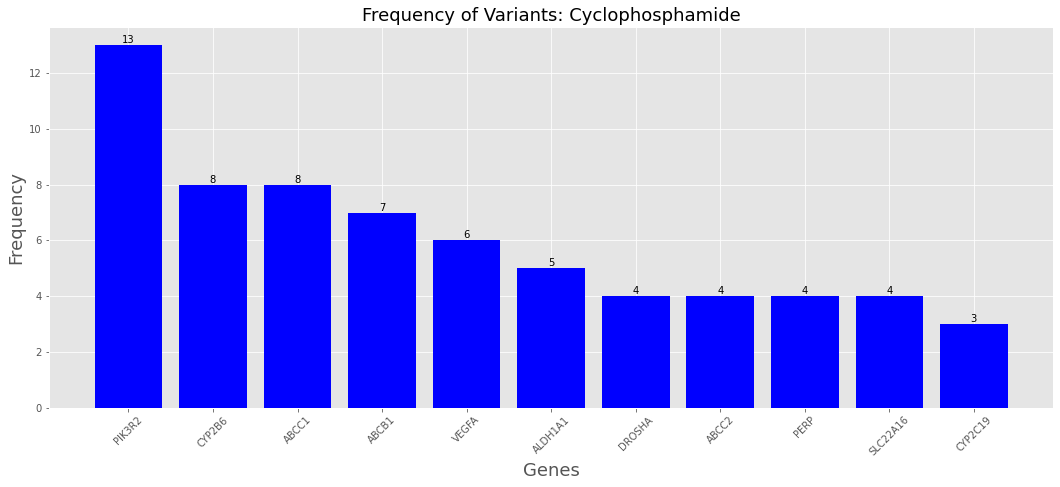

In [ ]:
from matplotlib import pyplot as plt

with plt.style.context("ggplot"):

  plt.figure(figsize=(18,7))
  plt.bar(genes,frequency,color="blue")
  plt.xticks(rotation = 90)
  plt.title("Frequency of Variants: Cyclophosphamide",fontsize=18)
  plt.xlabel("Genes",fontsize=18)
  plt.ylabel("Frequency",fontsize = 18)
  plt.xticks(rotation = 45)
  for i in range(len(frequency)):
    plt.annotate(str(frequency[i]), xy=(genes[i],frequency[i]), ha='center', va='bottom')
  plt.show()

In [ ]:
known_genes_cyclophosphamide["Phenotype Categories"].value_counts()

Toxicity                           141
Efficacy                            42
Metabolism/PK,Toxicity               4
Efficacy,Metabolism/PK,Toxicity      4
Metabolism/PK                        4
Name: Phenotype Categories, dtype: int64

In [ ]:
#### import tqdm library
import tqdm
from tqdm.notebook import tqdm
#### define a function that would run the process:
def frequency_table(*,snp_id = None,gene_name = None,gene_consequence = None):

  ### create access link to file
  """
  Args:
    snp_id: pass the snp_id for given gene
    gene_name : pass the corresponding gene
    gene_consequence: effect of that particular gene.

  """
  first_link = "https://www.ncbi.nlm.nih.gov/snp/"
  snp_id = str(snp_id)
  last_link = "/download/frequency"

  actual_link = first_link + snp_id + last_link ###### combine the names

  try:
    #### check for access of the url:

    url_access = requests.get(actual_link)
    text = url_access.text
    text_list = text.split("#################")[1] ### split the raw text into two separate strings.
    texts = text_list.split("\n")[1:-1]
    data = pd.DataFrame([x.split("\t") for x in texts])    ### convert the raw text into dataframe
    data.columns = data.iloc[0]     ### set the first row as the header
    data = data.drop(data.index[0])   ### drop the row with the header:
    data["gene"] = gene_name
    data["gene_consequence"] = gene_consequence
    data["snp_id"] = snp_id
    return data
  except:

    print(f"There is no info for the snp_id entered: {snp_id}")
    data = []
    return data




#### compile all the data
def compile_data(snps_data = None):

  """
  Takes the compile data:

  """
  list_of_data = []

  for index, rows in tqdm(snps_data.iterrows()):

    data = frequency_table(snp_id = rows["Variant"],gene_name = rows["Genes"], gene_consequence = rows["Gene_consequence"])
    if type(data) == pd.core.frame.DataFrame:
      data = data
    else:
      continue

    list_of_data.append(data)


  data_allele_frequency = pd.concat(list_of_data)
  """
  Return:
    the compiled dataset
  """
  return data_allele_frequency

In [ ]:
#### run the dataframe:
data = compile_data(snps_data = known_genes_cyclophosphamide)

0it [00:00, ?it/s]

There is no info for the snp_id entered: rs1799735


In [ ]:
### reset the data by drop unordered index.
data = data.reset_index(drop=True)

In [ ]:
data_cyclophosphamide = data

In [ ]:
data_cyclophosphamide.head()

0           #Study Population       Group Samplesize  Ref Allele  Alt Allele  \
0           TopMed     Global  Study-wide     264690  A=0.400892  G=0.599108   
1  gnomAD - Exomes     Global  Study-wide     251312  A=0.495703  G=0.504297   
2  gnomAD - Exomes   European         Sub     135256  A=0.546201  G=0.453799   
3  gnomAD - Exomes      Asian         Sub      48998   A=0.51590   G=0.48410   
4  gnomAD - Exomes   American         Sub      34588   A=0.45186   G=0.54814   

0 BioProject ID  BioSample ID   gene          gene_consequence     snp_id  
0   PRJNA400167                ABCB1  ABCB1 : Missense Variant  rs1045642  
1   PRJNA398795  SAMN07488253  ABCB1  ABCB1 : Missense Variant  rs1045642  
2                SAMN10181265  ABCB1  ABCB1 : Missense Variant  rs1045642  
3                              ABCB1  ABCB1 : Missense Variant  rs1045642  
4                SAMN07488255  ABCB1  ABCB1 : Missense Variant  rs1045642

In [ ]:
data_cyclophosphamide.to_csv("cyclophosphamide_alle_frequency.csv",index = False)

In [ ]:
%pwd

'/content/drive/MyDrive/Yemaachi_works/Cyclophosphamide '

In [ ]:
%cd ..
%pwd

/content/drive/MyDrive/Yemaachi_works


'/content/drive/MyDrive/Yemaachi_works'

### Analyse the known genes for capecitabine:

- Download both clinical and variants data from pharmgkb database.

In [ ]:
worksheet = gc.open('variants_gene_pairs').sheet1
rows = worksheet.get_all_values()
df_variant_genes_capecitabine = pd.DataFrame.from_records(rows[1:],columns=rows[0])
df_variant_genes_capecitabine.head(10)

PharmGKB ID     Variant        Literature   Genes Phenotype Categories  \
0  1449731693   rs3918290     PMID:30114658    DPYD             Toxicity   
1  1448568402   rs1801158     PMID:27995989    DPYD             Toxicity   
2  1448568409   rs2612091     PMID:27995989  ENOSF1             Toxicity   
3   827817287      rs9937     PMID:22026922    RRM1             Efficacy   
4  1448568388     rs11479     PMID:27995989    TYMP             Toxicity   
5  1451147880   rs1801159     PMID:32378051    DPYD             Toxicity   
6  1448568395  rs56038477     PMID:27995989    DPYD             Toxicity   
7  1446908428  rs61764370  PMCID:PMC4551162    KRAS             Efficacy   
8  1184511648  rs45445694     PMID:23263912    TYMS             Efficacy   
9  1450953284   rs1801265     PMID:20819423    DPYD             Toxicity   

                                           Molecules  \
0                         capecitabine; fluorouracil   
1  bevacizumab; capecitabine; cisplatin; docetaxe...   
2  bevacizumab; capecitabine; cisplatin; docetaxe...   
3  capecitabine; cisplatin; docetaxel; epirubicin...   
4  bevacizumab; capecitabine; cisplatin; docetaxe...   
5                                       capecitabine   
6  bevacizumab; capecitabine; cisplatin; docetaxe...   
7               capecitabine; cetuximab; oxaliplatin   
8                           capecitabine; paclitaxel   
9                         capecitabine; fluorouracil   

                                    Gene_consequence  
0                        DPYD : Splice Donor Variant  
1                            DPYD : Missense Variant  
2                            ENOSF1 : Intron Variant  
3                          RRM1 : Synonymous Variant  
4           TYMP : Stop Gained SCO2 : Intron Variant  
5                            DPYD : Missense Variant  
6                          DPYD : Synonymous Variant  
7                         KRAS : 3 Prime UTR Variant  
8  TYMSOS : Intron Variant TYMS : 5 Prime UTR Var...  
9                            DPYD : Missense Variant

In [ ]:
df_variant_genes_capecitabine.Genes.value_counts()

DPYD       40
SPARC       8
HLA-G       8
CDA         7
UMPS        6
           ..
PTGS2       1
ADCY2       1
XRCC1       1
SLC28A1     1
CYP1A1      1
Name: Genes, Length: 72, dtype: int64

In [ ]:
df_variant_genes_capecitabine.Genes.unique()

array(['DPYD', 'ENOSF1', 'RRM1', 'TYMP', 'KRAS', 'TYMS', 'CYP1B1',
       'SMAD7', 'CDA', 'GSTP1', 'ABCB1', 'MTHFR', 'VEGFA', 'CES2',
       'MIR27A', 'ERCC1', 'HLA-G', 'MGAT4A', 'SLCO1B1', 'ERCC2',
       'SLC19A1', 'UMPS', 'REV3L', 'MTR', 'SHMT1', 'SLC22A7', 'TK1',
       'EXO1', 'PTEN', 'CYP19A1', 'SELE', 'UPB1', 'MTHFD1', 'WDR7',
       'DLG5', 'ENOSF1; TYMS', 'NSUN3', 'CDX2', 'PTGS2', 'ADCY2', 'XRCC1',
       'SLC28A1', 'PHC1', 'ABCC11', 'FAT1', 'TENM4', 'ANK3', 'DPYS',
       'MTRR', 'SMARCAD1', 'SSU72', 'MAN1A1', 'AREG', 'SPRY2', 'VPS13D',
       'TP53', 'NCOA7', 'MIR2054', 'CD96', 'ZMIZ1', 'CCDC77', 'ADGRG7',
       'CES1', 'CES1P1', 'SPARC', 'TMEM131L', 'SIRPA', 'LMNTD1', 'CCDC70',
       'APOBEC2', 'ARHGEF4', 'CYP1A1'], dtype=object)

In [ ]:
cape_genes = []
cape_frequency = []
for gene , freq in sorted(Counter(df_variant_genes_capecitabine.Genes).items(),key= lambda x: x[1] ,reverse=True)[:11]:
  cape_genes.append(gene)
  cape_frequency.append(freq)

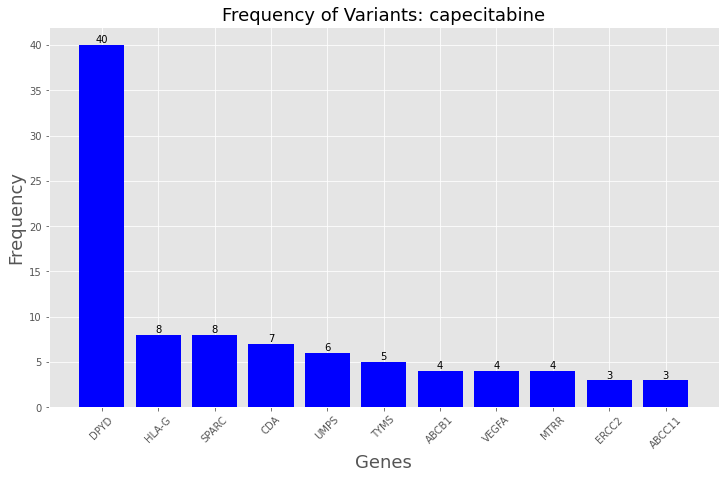

In [ ]:
with plt.style.context("ggplot"):

  plt.figure(figsize=(12,7))
  plt.bar(cape_genes,cape_frequency,color="blue")
  plt.xticks(rotation = 90)
  plt.title("Frequency of Variants: capecitabine",fontsize=18)
  plt.xlabel("Genes",fontsize=18)
  plt.ylabel("Frequency",fontsize = 18)
  plt.xticks(rotation = 45)
  for i in range(len(cape_frequency)):
    plt.annotate(str(cape_frequency[i]), xy=(cape_genes[i],cape_frequency[i]), ha='center', va='bottom')
  plt.show()

In [ ]:
df_variant_genes_capecitabine["Phenotype Categories"].value_counts()

Toxicity           103
Efficacy            63
Metabolism/PK        2
Dosage,Toxicity      1
Name: Phenotype Categories, dtype: int64

In [ ]:
df_variant_genes_capecitabine[df_variant_genes_capecitabine["Molecules"] == "capecitabine"].shape

(76, 7)

In [ ]:
df_variant_genes_capecitabine[df_variant_genes_capecitabine["Molecules"] != "capecitabine"].shape

(93, 7)

In [ ]:
data_capecitabine = compile_data(snps_data = df_variant_genes_capecitabine)

0it [00:00, ?it/s]

In [ ]:
data_capecitabine.head()

0            #Study        Population       Group Samplesize  Ref Allele  \
1  gnomAD - Genomes            Global  Study-wide     140212  C=0.995257   
2  gnomAD - Genomes          European         Sub      75944   C=0.99227   
3  gnomAD - Genomes           African         Sub      42020   C=0.99941   
4  gnomAD - Genomes          American         Sub      13640   C=0.99817   
5  gnomAD - Genomes  Ashkenazi Jewish         Sub       3324    C=0.9937   

0  Alt Allele BioProject ID  BioSample ID  gene             gene_consequence  \
1  T=0.004743   PRJNA398795  SAMN07488253  DPYD  DPYD : Splice Donor Variant   
2   T=0.00773                SAMN10181265  DPYD  DPYD : Splice Donor Variant   
3   T=0.00059                SAMN07488254  DPYD  DPYD : Splice Donor Variant   
4   T=0.00183                SAMN07488255  DPYD  DPYD : Splice Donor Variant   
5    T=0.0063                SAMN07488252  DPYD  DPYD : Splice Donor Variant   

0     snp_id  
1  rs3918290  
2  rs3918290  
3  rs3918290  
4  rs3918290  
5  rs3918290

In [ ]:
data_capecitabine.to_csv("/content/drive/MyDrive/Yemaachi_works/Capecitabine/capecitabine_allele_frequency.csv",index = False)